# $\mathrm{CH_3OOH}$ (Methylhydroperoxide)

In [1]:
using Pkg 
Pkg.activate("../")

  Activating project at `~/gitrepos/activepure/Photolysis.jl/mcm`


In [2]:
using Plots, MLPlotRecipes
using HDF5
using Tables, DataFrames, CSV
using MLJ, MLJGaussianProcesses
using StatsBase 
using KernelFunctions
using ParameterHandling

In [3]:
include("./utils.jl")

filter_outliers (generic function with 1 method)

# Loading Data

In [4]:
h5_path = "../../data/photolysis_data.h5" 
species = "CH3OOH" 
nice_name = "Methylhydroperoxide"
λs, σs, T1s, T2s, source_idx, T_units, category, formula, λ_units, σ_units = get_raw_data(h5_path, species)

println(unique(T1s))

[295.0, 298.0, 297.0, 294.0]


In [5]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 


In [6]:
println(nrow(hr4000_df))
println(maximum(hr4000_df.λ))
println(minimum(hr4000_df.λ))

3648
1120.216
194.249


In [7]:
Δλ = 50 # nm for padding
df = data_to_df(λs, σs, T1s, T2s, source_idx; λ_lb=minimum(hr4000_df.λ)-Δλ, λ_ub=maximum(hr4000_df.λ)+Δλ)
println(nrow(df))
describe(df)

2025


4×7 DataFrame
 Row │ variable   mean           min          median      max         nmissing ⋯
     │ Symbol     Float64        Real         Float64     Real        Int64    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ λ          577.341        205.99       614.41      638.254            0 ⋯
   2 │ σ            6.74099e-21    1.012e-25    6.33e-25    3.75e-19         0
   3 │ T          297.891        294.0        298.0       298.0              0
   4 │ source_id    8.70815        1            9.0        14                0
                                                                1 column omitted

In [8]:
#idxs_298 = [i for i ∈ 1:size(T1s, 1) if T1s[i] == 298.0]
#unique(source_idx[idxs_298])
unique(df.T)
unique(df.source_id)

n_sources = size(unique(df.source_id),1)

source_colors = distinguishable_colors(n_sources)

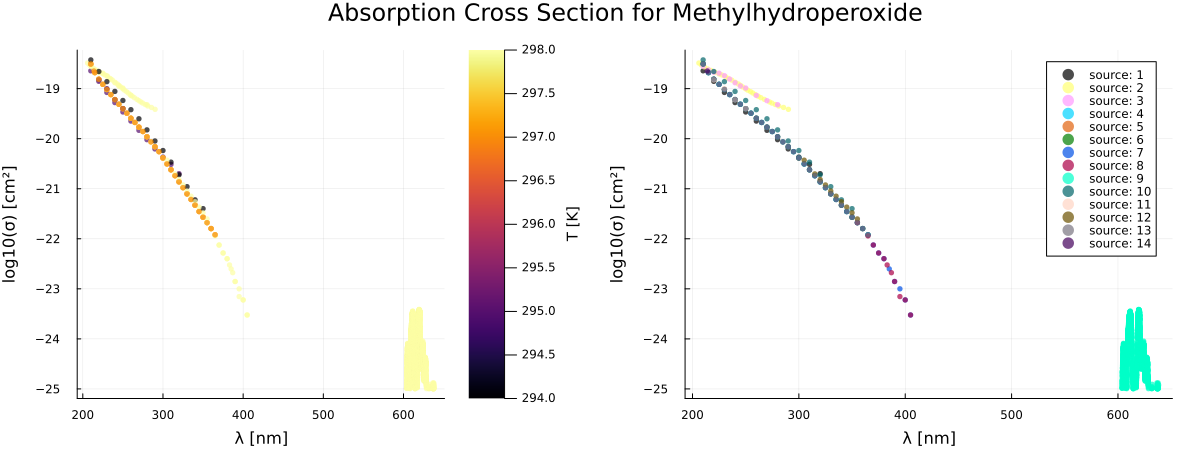

In [9]:
nskip = 1

p2 = scatter(
    df.λ[1:nskip:end],
    log10.(df.σ[1:nskip:end]),
    zcolor=df.T[1:nskip:end],
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    colorbar_title="T [$(T_units)]",
    label="",
)


gdf = groupby(df, :source_id)
p3 = plot()
i = 1
for df_g ∈ gdf 
    scatter!(
        df_g.λ[1:nskip:end],
        log10.(df_g.σ[1:nskip:end]),
        color = source_colors[i],
        ms=3, 
        msw=0,
        xlabel="λ [$(λ_units)]",
        ylabel="log10(σ) [cm²]",
        alpha=0.7,
        label="source: $(df_g.source_id[1])",
    )
    i += 1 
end

plot(p2, p3, layout=(1,2), size=(1200, 450), margin=5Plots.mm, plot_title="Absorption Cross Section for $(nice_name)",)

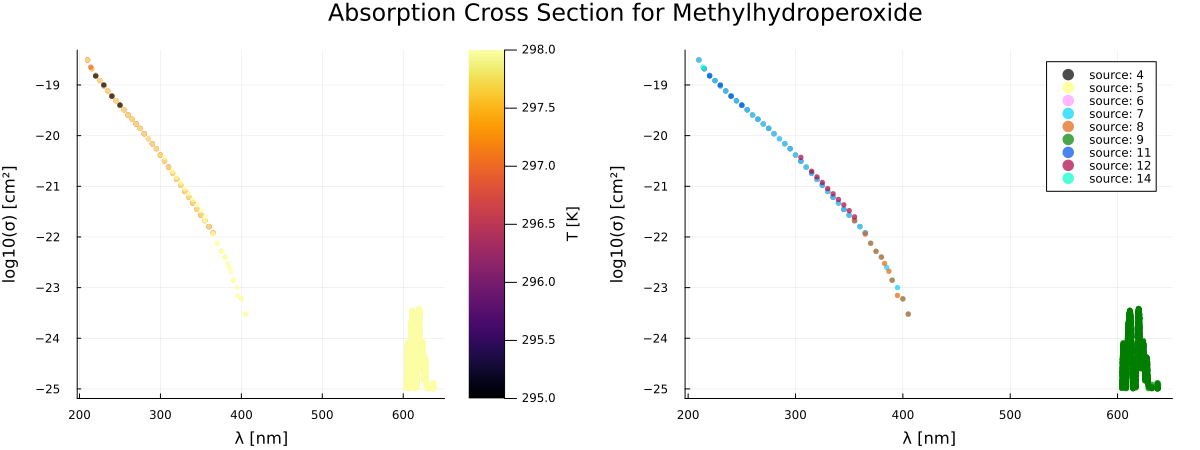

In [16]:
# let's drop source 2 and 3
df = df[df.source_id .!= 1 .&& df.source_id .!= 2 .&& df.source_id .!= 3 .&& df.source_id .!= 10, :]


p2 = scatter(
    df.λ[1:nskip:end],
    log10.(df.σ[1:nskip:end]),
    zcolor=df.T[1:nskip:end],
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    colorbar_title="T [$(T_units)]",
    label="",
)


gdf = groupby(df, :source_id)
p3 = plot()
i = 1
for df_g ∈ gdf 
    scatter!(
        df_g.λ[1:nskip:end],
        log10.(df_g.σ[1:nskip:end]),
        color = source_colors[i],
        ms=3, 
        msw=0,
        xlabel="λ [$(λ_units)]",
        ylabel="log10(σ) [cm²]",
        alpha=0.7,
        label="source: $(df_g.source_id[1])",
    )
    i += 1 
end

plot(p2, p3, layout=(1,2), size=(1200, 450), margin=5Plots.mm, plot_title="Absorption Cross Section for $(nice_name)",)

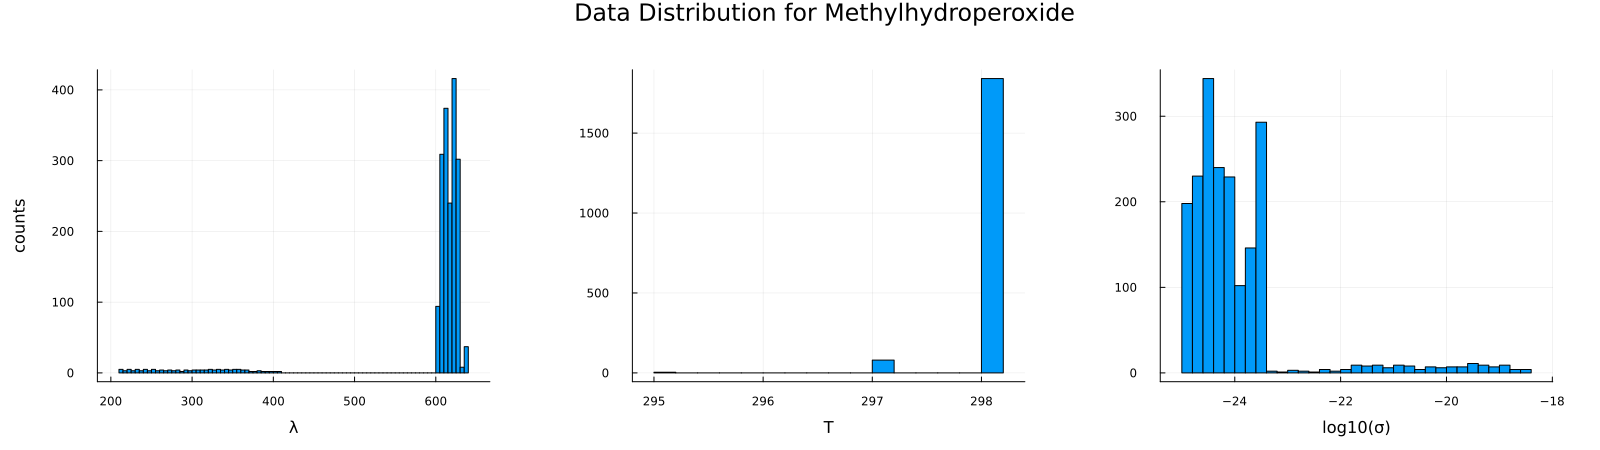

In [17]:
p1 = histogram(df.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Data Distribution for $(nice_name)")

In [18]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

In [19]:
println(nrow(hr4000_df))
println(maximum(hr4000_df.λ))
println(minimum(hr4000_df.λ))

3648
1120.216
194.249


# Data Preprocessing

In [20]:
gdfs = groupby(df, :T)

res_dfs = []

for gdf ∈ gdfs
    gdf_by_λ = groupby(gdf, :λ)
    push!(res_dfs, combine(gdf_by_λ, [:σ, :T] .=> mean, renamecols = false))
end

df_unique = vcat(res_dfs...)

1859×3 DataFrame
  Row │ λ        σ          T       
      │ Float64  Float64    Float64 
──────┼─────────────────────────────
    1 │ 220.0    1.5e-19      295.0
    2 │ 230.0    1.0e-19      295.0
    3 │ 240.0    6.0e-20      295.0
    4 │ 250.0    4.0e-20      295.0
    5 │ 210.0    3.12e-19     297.0
    6 │ 215.0    2.09e-19     297.0
    7 │ 220.0    1.54e-19     297.0
    8 │ 225.0    1.22e-19     297.0
    9 │ 230.0    9.62e-20     297.0
   10 │ 235.0    7.61e-20     297.0
   11 │ 240.0    6.05e-20     297.0
  ⋮   │    ⋮         ⋮         ⋮
 1850 │ 637.534  1.053e-25    298.0
 1851 │ 637.57   1.012e-25    298.0
 1852 │ 637.654  1.012e-25    298.0
 1853 │ 637.702  1.012e-25    298.0
 1854 │ 637.726  1.093e-25    298.0
 1855 │ 637.774  1.318e-25    298.0
 1856 │ 637.786  1.032e-25    298.0
 1857 │ 637.93   1.032e-25    298.0
 1858 │ 637.99   1.114e-25    298.0
 1859 │ 638.254  1.195e-25    298.0
                   1838 rows omitted

For whatever reason, the fit doesn't work with both ranges. So I'm just going to combine two separate fits

In [21]:
# df_unique = filter_outliers(df_unique, log10.(df_unique.σ); frac=5)
# println(nrow(df_unique))

#df_unique = df_unique[df_unique.T .== 298.0, :]
df_unique1 = df_unique[df_unique.λ .< 500.0, :]
df_unique2 = df_unique[df_unique.λ .> 500.0, :]


1780×3 DataFrame
  Row │ λ        σ          T       
      │ Float64  Float64    Float64 
──────┼─────────────────────────────
    1 │ 603.856  1.053e-25    298.0
    2 │ 603.88   1.053e-25    298.0
    3 │ 603.892  1.032e-25    298.0
    4 │ 603.916  1.032e-25    298.0
    5 │ 603.928  1.318e-25    298.0
    6 │ 603.94   1.338e-25    298.0
    7 │ 603.952  1.216e-25    298.0
    8 │ 603.964  1.256e-25    298.0
    9 │ 603.976  1.134e-25    298.0
   10 │ 603.988  1.195e-25    298.0
   11 │ 604.0    1.114e-25    298.0
  ⋮   │    ⋮         ⋮         ⋮
 1771 │ 637.534  1.053e-25    298.0
 1772 │ 637.57   1.012e-25    298.0
 1773 │ 637.654  1.012e-25    298.0
 1774 │ 637.702  1.012e-25    298.0
 1775 │ 637.726  1.093e-25    298.0
 1776 │ 637.774  1.318e-25    298.0
 1777 │ 637.786  1.032e-25    298.0
 1778 │ 637.93   1.032e-25    298.0
 1779 │ 637.99   1.114e-25    298.0
 1780 │ 638.254  1.195e-25    298.0
                   1759 rows omitted

In [23]:
df_sampled1 = df_unique1
df_sampled2 = df_unique2


1780×3 DataFrame
  Row │ λ        σ          T       
      │ Float64  Float64    Float64 
──────┼─────────────────────────────
    1 │ 603.856  1.053e-25    298.0
    2 │ 603.88   1.053e-25    298.0
    3 │ 603.892  1.032e-25    298.0
    4 │ 603.916  1.032e-25    298.0
    5 │ 603.928  1.318e-25    298.0
    6 │ 603.94   1.338e-25    298.0
    7 │ 603.952  1.216e-25    298.0
    8 │ 603.964  1.256e-25    298.0
    9 │ 603.976  1.134e-25    298.0
   10 │ 603.988  1.195e-25    298.0
   11 │ 604.0    1.114e-25    298.0
  ⋮   │    ⋮         ⋮         ⋮
 1771 │ 637.534  1.053e-25    298.0
 1772 │ 637.57   1.012e-25    298.0
 1773 │ 637.654  1.012e-25    298.0
 1774 │ 637.702  1.012e-25    298.0
 1775 │ 637.726  1.093e-25    298.0
 1776 │ 637.774  1.318e-25    298.0
 1777 │ 637.786  1.032e-25    298.0
 1778 │ 637.93   1.032e-25    298.0
 1779 │ 637.99   1.114e-25    298.0
 1780 │ 638.254  1.195e-25    298.0
                   1759 rows omitted

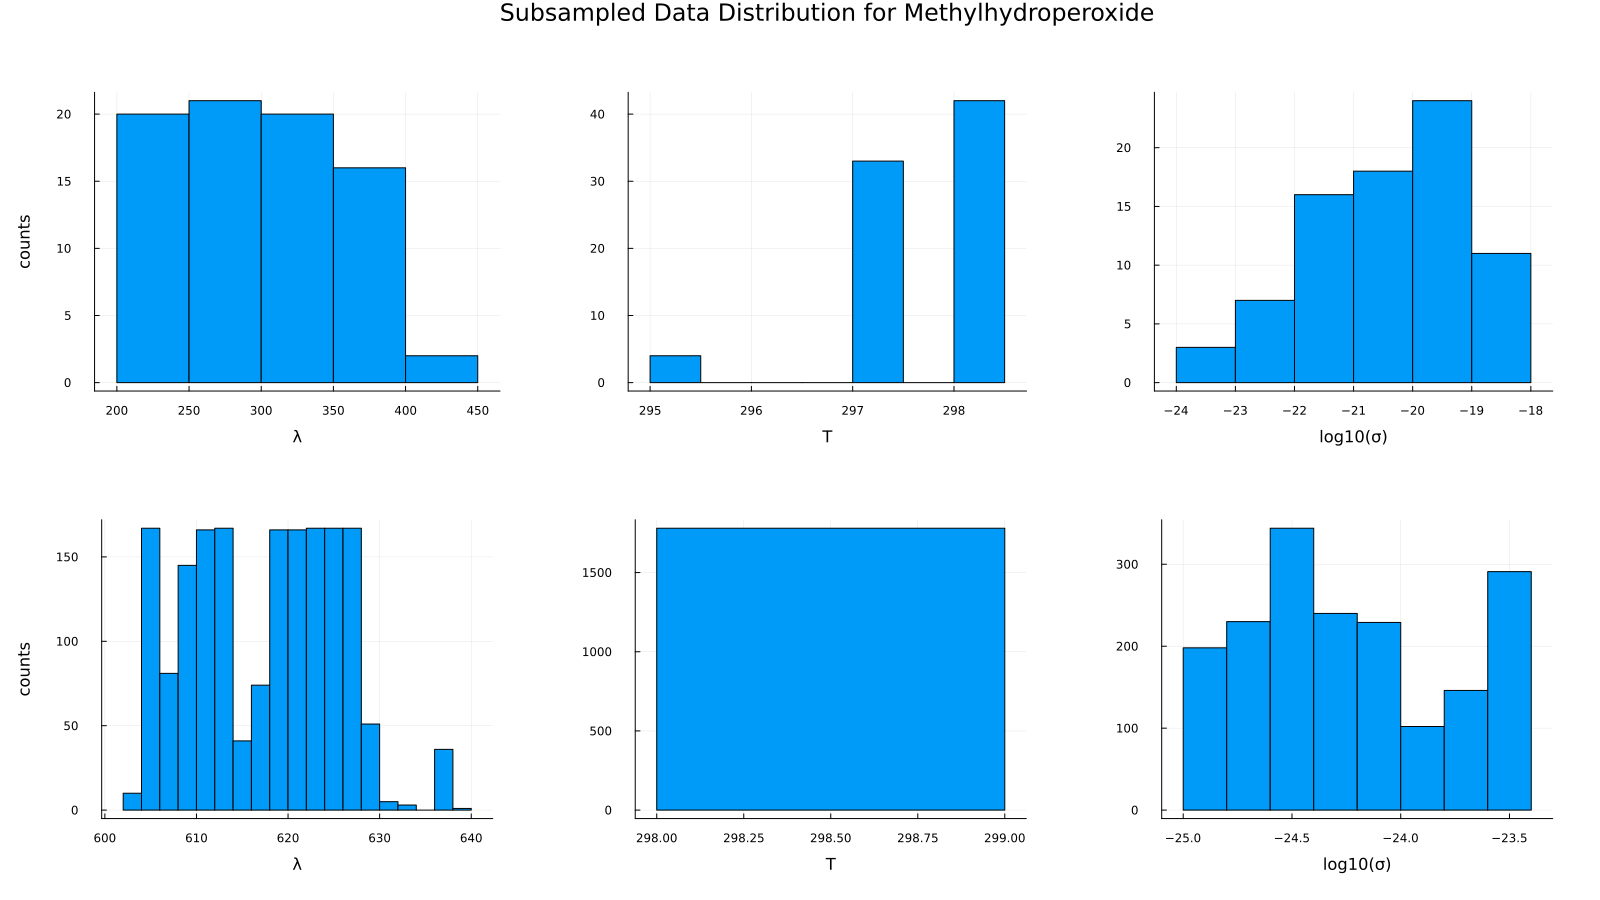

In [24]:
p1 = histogram(df_sampled1.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df_sampled1.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df_sampled1.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)


p4 = histogram(df_sampled2.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p5 = histogram(df_sampled2.T, xlabel="T", label="", margin=10Plots.mm)
p6 = histogram(log10.(df_sampled2.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)

#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist1 = plot(p1, p2, p3, layout=(1,3))
phist2 = plot(p4, p5, p6, layout=(1,3))
plot(phist1, phist2, layout=(2,1), size=(1600, 900), plot_title="Subsampled Data Distribution for $(nice_name)")

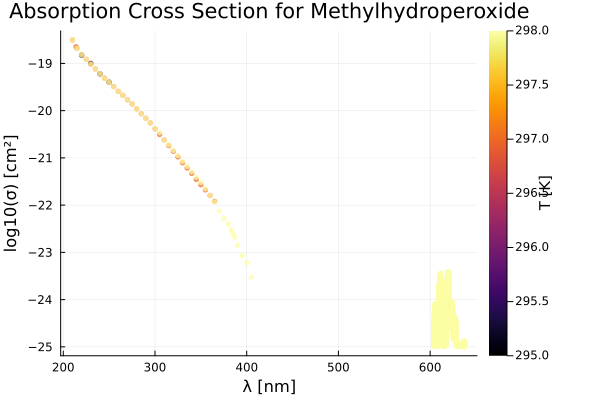

In [25]:
p = scatter(
    df_sampled1.λ,
    log10.(df_sampled1.σ),
    zcolor=df_sampled1.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)

scatter!(
    df_sampled2.λ,
    log10.(df_sampled2.σ),
    zcolor=df_sampled2.T,
    ms=3, 
    msw=0,
    alpha=0.7,
    label="",
)

# GPR Fit

In [30]:
train_frac = 0.9
ntrain1 = trunc(Int, train_frac * nrow(df_sampled1))
ntrain2 = trunc(Int, train_frac * nrow(df_sampled2))
println(ntrain1)
println(ntrain2)

71
1602


In [32]:
idxs = shuffle(1:nrow(df_sampled1))
idxs_train = idxs[1:ntrain1]
idxs_test = idxs[ntrain1+1:end]

Xtrain1 = df_sampled1[idxs_train, [:λ, :T]]
Xtest1 = df_sampled1[idxs_test, [:λ, :T]]

ytrain1 = log10.(df_sampled1.σ[idxs_train])
ytest1 = log10.(df_sampled1.σ[idxs_test])


idxs = shuffle(1:nrow(df_sampled2))
idxs_train = idxs[1:ntrain2]
idxs_test = idxs[ntrain2+1:end]

Xtrain2 = df_sampled2[idxs_train, [:λ, :T]]
Xtest2 = df_sampled2[idxs_test, [:λ, :T]]

ytrain2 = log10.(df_sampled2.σ[idxs_train])
ytest2 = log10.(df_sampled2.σ[idxs_test])

178-element Vector{Float64}:
 -24.466482137983032
 -23.451733454829256
 -24.95311480916229
 -23.509199047989146
 -23.802443786846464
 -24.73826145264746
 -24.438898616350944
 -23.555174800490253
 -24.705533773838408
 -24.929962133392245
 -24.38626385873813
 -24.32048125630421
 -24.768275616671485
   ⋮
 -24.72399801003795
 -24.620331965966347
 -24.25212229418021
 -24.17282465170131
 -24.929962133392245
 -23.46445272082333
 -24.381951903287906
 -24.434034182553333
 -24.99481948749622
 -24.542723813938675
 -24.314975214894286
 -24.69680394257951

In [33]:
# compute length scales
κ = 1
ℓ_λ = std(Xtrain1.λ)/κ
ℓ_T = std(Xtrain1.T)/κ
println("ℓ_λ: ",ℓ_λ)
println("ℓ_T: ",ℓ_T)


# compute variance parameters
SNR = 200.0
σf² = 10*(var(ytrain1))
σₙ² = (sqrt(σf²)/SNR)^2
println("σf²: ", σf²)
println("σₙ²: ", σₙ²)

# set up initial values list
θ_init = (σf²=positive(σf²), ℓ_λ=positive(ℓ_λ), ℓ_T=positive(ℓ_T))

function mykernel(θ::NamedTuple)
    return θ.σf² * with_lengthscale(SqExponentialKernel(), [θ.ℓ_λ, θ.ℓ_T])
end

ℓ_λ: 57.526074395985646
ℓ_T: 0.7667643480185774
σf²: 17.59383507581376
σₙ²: 0.0004398458768953441


mykernel (generic function with 1 method)

In [34]:
μ_init = -30.0
gpr1 = GPR(
    μ=μ_init,
    k=mykernel,
    θ_init=θ_init,
    σ²=σₙ²,
)

GPR(
  μ = -30.0, 
  k = mykernel, 
  θ_init = (σf² = ParameterHandling.Positive{Float64, typeof(exp), Float64}(2.8675485600515507, exp, 1.4901161193847656e-8), ℓ_λ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(4.0522383125151125, exp, 1.4901161193847656e-8), ℓ_T = ParameterHandling.Positive{Float64, typeof(exp), Float64}(-0.26557578282383615, exp, 1.4901161193847656e-8)), 
  σ² = 0.0004398458768953441, 
  optimizer = Optim.LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}(10, LineSearches.InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
, nothing, Optim.var"#19#21"(), Optim.Flat(), true))

In [35]:
mach1 = machine(gpr1, Xtrain1, ytrain1) |> fit!

[ Info: Training machine(GPR(μ = -30.0, …), …).


Iter     Function value   Gradient norm 
     0    -9.893031e+01     4.315581e+01
 * time: 0.01742100715637207
     1    -1.109709e+02     3.397661e+01
 * time: 0.881788969039917
     2    -1.180967e+02     3.288415e+01
 * time: 0.885308027267456
     3    -1.205627e+02     1.145028e+01
 * time: 0.8911769390106201
     4    -1.265538e+02     1.270931e+01
 * time: 0.8978090286254883
     5    -1.336745e+02     2.211500e+01
 * time: 0.9042069911956787
     6    -1.426080e+02     2.312475e+01
 * time: 0.9089400768280029
     7    -1.489027e+02     1.301516e+01
 * time: 0.9146881103515625
     8    -1.503595e+02     3.984408e+00
 * time: 0.9193620681762695
     9    -1.521300e+02     7.109759e+00
 * time: 0.9243650436401367
    10    -1.527228e+02     2.411988e+00
 * time: 0.9289779663085938
    11    -1.528937e+02     1.733338e+00
 * time: 0.9339559078216553
    12    -1.534226e+02     8.317302e+00
 * time: 0.9398651123046875
    13    -1.538134e+02     3.601772e+00
 * time: 0.94286894798

trained Machine; caches model-specific representations of data
  model: GPR(μ = -30.0, …)
  args: 
    1:	Source @932 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @917 ⏎ AbstractVector{Continuous}


In [37]:
# compute length scales
κ = 1
ℓ_λ = std(Xtrain2.λ)/κ
ℓ_T = 0.1 # std(Xtrain2.T)/κ
println("ℓ_λ: ",ℓ_λ)
println("ℓ_T: ",ℓ_T)


# compute variance parameters
SNR = 5.0
σf² = 2*(var(ytrain2))
σₙ² = (sqrt(σf²)/SNR)^2
println("σf²: ", σf²)
println("σₙ²: ", σₙ²)

# set up initial values list
θ_init = (σf²=positive(σf²), ℓ_λ=positive(ℓ_λ), ℓ_T=positive(ℓ_T))

function mykernel(θ::NamedTuple)
    return θ.σf² * with_lengthscale(SqExponentialKernel(), [θ.ℓ_λ, θ.ℓ_T])
end

ℓ_λ: 7.925185360748651
ℓ_T: 0.1
σf²: 0.43353625394408696
σₙ²: 0.017341450157763477


mykernel (generic function with 1 method)

In [38]:
μ_init = -30.0
gpr2 = GPR(
    μ=μ_init,
    k=mykernel,
    θ_init=θ_init,
    σ²=σₙ²,
)

GPR(
  μ = -30.0, 
  k = mykernel, 
  θ_init = (σf² = ParameterHandling.Positive{Float64, typeof(exp), Float64}(-0.8357798898473923, exp, 1.4901161193847656e-8), ℓ_λ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(2.0700457069785037, exp, 1.4901161193847656e-8), ℓ_T = ParameterHandling.Positive{Float64, typeof(exp), Float64}(-2.3025852420056685, exp, 1.4901161193847656e-8)), 
  σ² = 0.017341450157763477, 
  optimizer = Optim.LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}(10, LineSearches.InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
, nothing, Optim.var"#19#21"(), Optim.Flat(), true))

In [39]:
mach2 = machine(gpr2, Xtrain2, ytrain2) |> fit!

[ Info: Training machine(GPR(μ = -30.0, …), …).


Iter     Function value   Gradient norm 
     0     4.686145e+03     5.287296e+03
 * time: 0.0001659393310546875
     1     7.839165e+02     7.737291e+02
 * time: 6.669729948043823
     2    -6.553976e+02     6.844308e+02
 * time: 8.292700052261353
     3    -1.442884e+03     1.398634e+03
 * time: 9.9704909324646
     4    -2.215642e+03     2.992608e+03
 * time: 11.208348035812378
     5    -2.745200e+03     2.116860e+02
 * time: 12.70937705039978
     6    -2.771206e+03     1.596545e+02
 * time: 13.924200057983398
     7    -2.801173e+03     8.105886e+01
 * time: 14.712792873382568
     8    -2.806427e+03     5.792273e+01
 * time: 15.922860860824585
     9    -2.810588e+03     4.483026e+01
 * time: 17.158686876296997
    10    -2.827403e+03     1.798974e+02
 * time: 18.7931809425354
    11    -2.832110e+03     3.209260e+00
 * time: 19.57203698158264
    12    -2.832115e+03     1.058819e-01
 * time: 20.88582491874695
    13    -2.832117e+03     7.582015e-02
 * time: 22.06101107597351
 

trained Machine; caches model-specific representations of data
  model: GPR(μ = -30.0, …)
  args: 
    1:	Source @365 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @982 ⏎ AbstractVector{Continuous}


# Model Evaluation

In [40]:
rpt1 = report(mach1)

(summary = "L-BFGS",
 minimizer = [4.341076371773354, 4.634592169483885, 6.79836287039816, -8.194675697204483],
 minimum = -153.86466262418267,
 iterations = 65,
 converged = true,)

In [41]:
rpt2 = report(mach2)

(summary = "L-BFGS",
 minimizer = [2.535187068718342, -0.04494485338467927, -2.3023785028212806, -6.677833627630452],
 minimum = -2832.1175429087994,
 iterations = 30,
 converged = true,)

In [42]:
fp1 = fitted_params(mach1)

(θ_best = [:σf² => 76.79014963505584, :ℓ_λ => 102.9859086480924, :ℓ_T => 896.3786018320579],
 σ² = 0.0002761347097892577,)

In [43]:
fp2 = fitted_params(mach2)

(θ_best = [:σf² => 12.618791223254764, :ℓ_λ => 0.9560502182133316, :ℓ_T => 0.10002067605255963],
 σ² = 0.0012585163053439883,)

In [44]:
y_pred_train1 = predict_mean(mach1, Xtrain1);
y_pred_test1 = predict_mean(mach1, Xtest1);

y_pred_train2 = predict_mean(mach2, Xtrain2);
y_pred_test2 = predict_mean(mach2, Xtest2);

now let's collect some more points in order to evaluate our model using indices other than the ones used during training. 


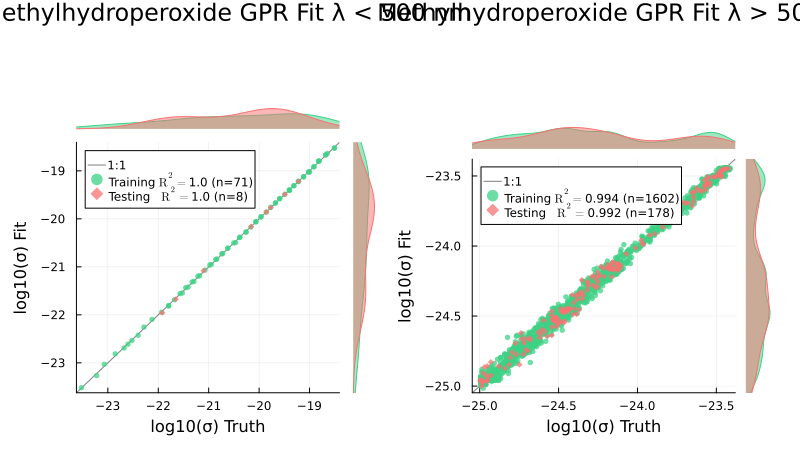

In [48]:
p = scatterresult(
    ytrain1, y_pred_train1,
    ytest1, y_pred_test1,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    plot_title="$(nice_name) GPR Fit λ < 500 nm"
)

p2 = scatterresult(
    ytrain2, y_pred_train2,
    ytest2, y_pred_test2,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    plot_title="$(nice_name) GPR Fit λ > 500 nm"
)

plot(p, p2, layout=(1,2), size=(800, 450), margins=5Plots.mm)

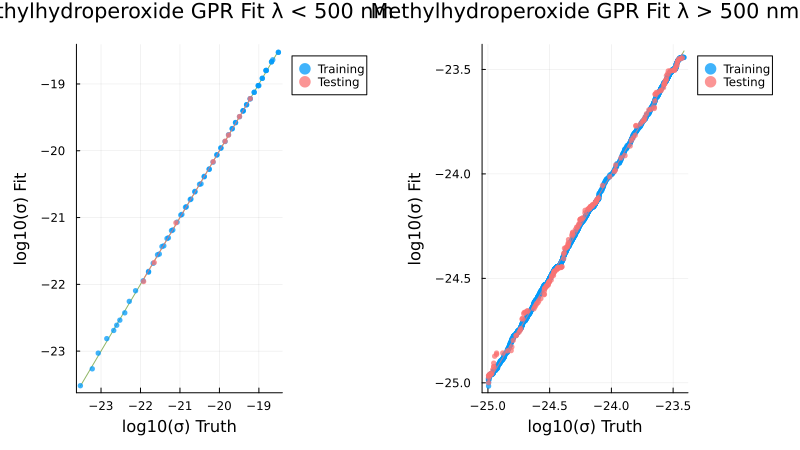

In [50]:
p = quantilequantile(
    ytrain1, y_pred_train1,
    ytest1, y_pred_test1,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    title="$(nice_name) GPR Fit λ < 500 nm"
)


p2 = quantilequantile(
    ytrain2, y_pred_train2,
    ytest2, y_pred_test2,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    title="$(nice_name) GPR Fit λ > 500 nm"
)

plot(p, p2, layout=(1,2), size=(800, 450), margins=5Plots.mm)

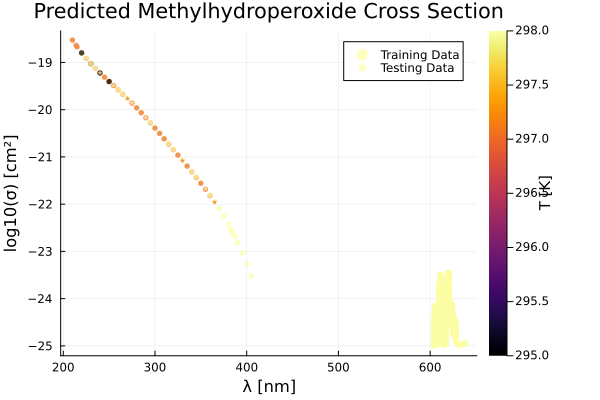

In [52]:
p1 = scatter(
    Xtrain1.λ,
    y_pred_train1,
    zcolor=Xtrain1.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    label="Training Data",
)

scatter!(
    Xtest1.λ,
    y_pred_test1,
    zcolor=Xtest1.T,
    ms=3, 
    msw=0,
    # markershape=:rect,
    markershape=:star5,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Predicted $(nice_name) Cross Section",
    label="Testing Data",
)


scatter!(
    Xtrain2.λ,
    y_pred_train2,
    zcolor=Xtrain2.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    label="",
)

scatter!(
    Xtest2.λ,
    y_pred_test2,
    zcolor=Xtest2.T,
    ms=3, 
    msw=0,
    # markershape=:rect,
    markershape=:star5,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Predicted $(nice_name) Cross Section",
    label="",
)


Finally, let's try prediction at the desired wavelength bins: 

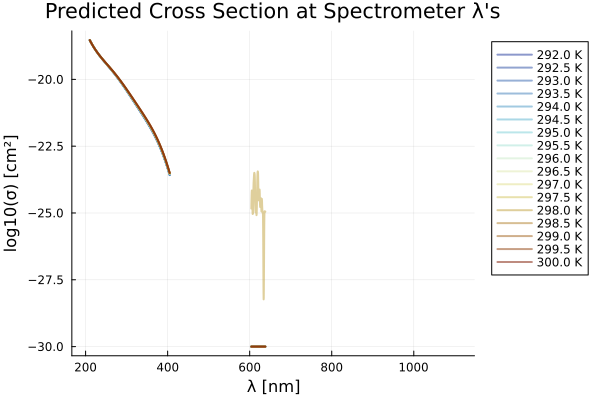

In [54]:
λ_min1 = maximum([minimum(df_sampled1.λ), minimum(hr4000_df.λ)])
λ_max1 = minimum([maximum(df_sampled1.λ), maximum(hr4000_df.λ)])

λ_min2 = maximum([minimum(df_sampled2.λ), minimum(hr4000_df.λ)])
λ_max2 = minimum([maximum(df_sampled2.λ), maximum(hr4000_df.λ)])


p = plot()

Ts = 292.0:0.5:300.0
# cs = cgrad(:thermal, Ts, categorical = true)
cs = cgrad(:roma, size(Ts,1), categorical = true, rev=true)
i = 1
for T ∈ Ts
    logσ1 = predict_logσ(T, hr4000_df, mach1, (λ_min1, λ_max1))
    logσ2 = predict_logσ(T, hr4000_df, mach2, (λ_min2, λ_max2))
    
    plot!(
        hr4000_df.λ, logσ1,
        linewidth=2,
        alpha=0.5,
        color=cs[i],
        label="$(T) K",
        legend=:outertopright,
    )
    
    plot!(
        hr4000_df.λ, logσ2,
        linewidth=2,
        alpha=0.5,
        color=cs[i],
        label="",
    )
    i+=1
end

xlabel!("λ [nm]")
ylabel!("log10(σ) [cm²]")
title!("Predicted Cross Section at Spectrometer λ's")

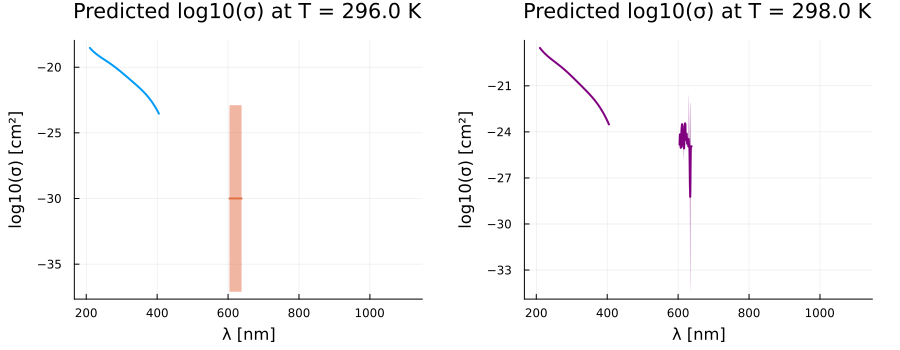

In [55]:

Tplot = 296.0
logσ1, Δlogσ1 = predict_logσ_wΔ(Tplot, hr4000_df, mach1, (λ_min1, λ_max1))
logσ2, Δlogσ2 = predict_logσ_wΔ(Tplot, hr4000_df, mach2, (λ_min2, λ_max2))

p1 = plot(
    hr4000_df.λ, logσ1,
    ribbon= 2 .* Δlogσ1,
    fillalpha=0.5,
    linewidth=2,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label="",
)
plot!(
    hr4000_df.λ, logσ2,
    ribbon= 2 .* Δlogσ2,
    fillalpha=0.5,
    linewidth=2,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label="",
)


Tplot = 298.0
logσ1, Δlogσ1 = predict_logσ_wΔ(Tplot, hr4000_df, mach1, (λ_min1, λ_max1))
logσ2, Δlogσ2 = predict_logσ_wΔ(Tplot, hr4000_df, mach2, (λ_min2, λ_max2))

p2 = plot(
    hr4000_df.λ, logσ1,
    ribbon= 2 .* Δlogσ1,
    fillalpha=0.5,
    linewidth=2,
    color=:purple,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label=""
)

plot!(
    hr4000_df.λ, logσ2,
    ribbon= 2 .* Δlogσ2,
    fillalpha=0.5,
    linewidth=2,
    color=:purple,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label=""
)


plot(p1, p2, layout=(1,2), margin=5Plots.mm, size=(900,350)) 